<a href="https://colab.research.google.com/github/hmelberg/health-analytics-using-python/blob/master/HTA_Markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Economic Evaluation using Markov models

Assume you somebody invents a new pharmaceutical that increases the probability that patients will recover from a disease. In order to estimate the benefits of this pharmaceutical, we could create a model and simulate the outcome in terms of costs and benefits for a large number of individuals with and without the disease. To do so we first make a model.

##A model of patient flow

Imagine that a parson can only be in one of three possible states: Healthy, Sick, Dead. In each time period there is a probability that a person may change state i.e. they may go from healthy to sick, or from sick to healthy. They may also die, and unfortunately, once you are dead the probability is very high that you will also be dead in the next time period. The positive, however, is that the new pharmaceutical should at least increase the probability of going from sick to healthy or reduce the probability of dying. We could write summarize the probabilies of goving from one state to another in a table, often called the transition matrix:



From/To|Healthy |Sick | Dead
-----|--|--|--|
Healthy|0.8|0.2| 0.1|
Sick|0.2|0.6| 0.2|
Dead|0|0| 1|

 

We could also visualize the information about the different states and transition probabilities in a graph:

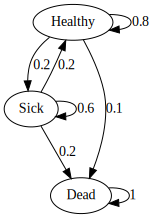

In [ ]:
from graphviz import Digraph

tree = Digraph()

tree.edge('Healthy', 'Healthy', '0.8')
tree.edge('Healthy', 'Sick', '0.2')
tree.edge('Healthy', 'Dead', '0.1')
tree.edge('Sick', 'Healthy', '0.2')
tree.edge('Sick', 'Sick', '0.6')
tree.edge('Sick', 'Dead', '0.2')
tree.edge('Dead', 'Dead' ,'1')

tree

# Simulation: How many individuals will be in the different states as time passes?
In order to find the number of healthy, sick, and dead people after a given nunmber of steps, we multiply the initial population with the transition matrix (matrix multiplication). This gives us the number of people the different states after one time period. The result for the next time period can be found by multiplying the new outcome by the transition matrix.

To do this in python, it is useful to use numpy and define the initial population as an array. Assume a ppulation of 1000 individuals who all start out as healthy, and nobudy are sick or dead, initially: 

In [ ]:
import numpy as np

initial_population=np.array([10000, 0 ,0])

Net, we need to create a transition matric.  

In [ ]:
transition_matrix = np.array([[0.8, 0.1, 0.1], [0.2, 0.6, 0.2], [0. , 0. , 1. ]])

We then multiply the initial population with the transition matrix to get the number og people who are healthy, sick and dead after the first time period. Note also that the symbol for matrix multiplication is @

In [ ]:
population_after_1_step =  initial_population @ transition_matrix
population_after_1_step

array([8000., 1000., 1000.])

To get the number of individuals after a second sep:

In [ ]:
population_after_2_step =  population_after_1_step @ transition_matrix
population_after_2_step

array([6600., 1400., 2000.])

Instead of doing it step by step, lets create a function that simulates x steps and sends the results back to us:

In [ ]:
def population_development(initial, probabilities, steps):
  current_population = initial
  population_history = np.empty(shape=(steps+1,len(initial)))
  population_history[0] = initial

  for step in range(steps):
    new_population = current_population @ probabilities
    population_history[step+1] = new_population
    current_population=new_population
  return population_history



In [ ]:
population=population_development(initial=initial_population, 
                       probabilities=transition_matrix, 
                       steps=20)
population.astype(int)

array([[10000,     0,     0],
       [ 8000,  1000,  1000],
       [ 6600,  1400,  2000],
       [ 5560,  1500,  2940],
       [ 4748,  1456,  3796],
       [ 4089,  1348,  4562],
       [ 3541,  1218,  5240],
       [ 3076,  1084,  5838],
       [ 2678,   958,  6363],
       [ 2334,   843,  6822],
       [ 2036,   739,  7224],
       [ 1776,   647,  7576],
       [ 1550,   565,  7883],
       [ 1353,   494,  8151],
       [ 1182,   432,  8385],
       [ 1032,   377,  8590],
       [  901,   329,  8769],
       [  786,   287,  8925],
       [  687,   251,  9061],
       [  599,   219,  9180],
       [  523,   191,  9284]])

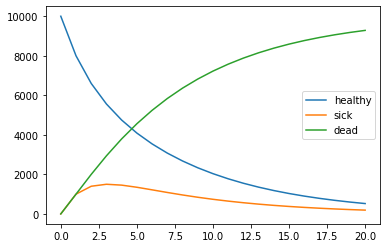

In [ ]:
import pandas as pd
df=pd.DataFrame(population)
df.columns=['healthy', 'sick', 'dead']
df.plot();

In [ ]:
utility = np.array([0.9, 0.5, 0])
utility

array([0.9, 0.5, 0. ])

In [ ]:
population @ utility

array([9000.        , 7700.        , 6640.        , 5754.        ,
       5001.2       , 4354.84      , 3796.224     , 3311.4872    ,
       2889.81904   , 2522.462544  , 2202.1308032 , 1922.65035424,
       1678.73032646, 1465.8032941 , 1279.90866157, 1117.60261091,
        975.88567095,  852.14273831,  744.092425  ,  649.74373538,
        567.35871403])

In [ ]:
cost = np.array([0,1000,0])
population @ cost

array([      0.        , 1000000.        , 1400000.        ,
       1500000.        , 1456000.        , 1348400.        ,
       1218000.        , 1084936.        ,  958630.4       ,
        843012.        ,  739246.816     ,  647160.0224    ,
        565970.496     ,  494665.084096  ,  432184.6895744 ,
        377512.62672   ,  329712.72020378,  287941.99999409,
        251450.94869798,  219578.0081799 ,  191741.77505078])

In [ ]:
def descriptives(initial, probabilities, utility, cost, steps):
  population = population_development(initial=initial, probabilities=probabilities, steps=steps)
  n_population = initial.sum()

  tot_cost = (population @ cost).sum()
  avg_cost = tot_cost/n_population

  tot_utility = (population @ utility).sum()
  avg_utility = tot_utility/n_population
  
  return avg_cost, avg_utility



In [ ]:
descriptives(initial=initial_population, 
             probabilities = transition_matrix,
             utility=utility,
             cost=cost, 
             steps=20)

(1534.6143586916928, 6.442608211813452)

## New treatment

In [ ]:
new_transition_matrix = np.array([[0.8, 0.1, 0.1], [0.3, 0.6, 0.1], [0. , 0. , 1. ]])
new_cost = np.array([0,2000,0])

In [ ]:
%%timeit
descriptives(initial=initial_population, 
             probabilities = new_transition_matrix,
             utility=utility,
             cost=new_cost, 
             steps=20)

TypeError: ignored

In [ ]:
def icer(initial, old_matrix, old_utility, old_cost, new_matrix, new_utility, new_cost, steps):
  old_cost, old_utility = descriptives(initial=initial,  probabilities = old_matrix,  utility=old_utility,  cost=old_cost, steps=steps)
  new_cost, new_utility = descriptives(initial=initial,  probabilities = new_matrix,  utility=new_utility,  cost=new_cost, steps=steps)
  icer = (new_cost - old_cost)/(new_utility - old_utility)
  return icer

In [ ]:
icer(initial=initial_population,
     old_matrix=transition_matrix,
     old_cost=cost,
     old_utility=utility,
     new_matrix=new_transition_matrix,
     new_cost=new_cost,
     new_utility=utility,
     steps=20)


2174.8352132084106

# Challenge 1: Probability of death may depend on time

So far we have assumed that the probability of dying is is the same as time passes. Regardles of how much time has passes, the probability that you will die if you get sick, is 0.2 in every time period while you are sick. This seems wrong. A more realistic assumption - if the time period to be considered spans several years - would be to make the probability of dying increase as time passes i.e. as people get older. The figure below visualizes the model with both deaths from a disease and deats from age:


In [ ]:
#simplify graphs making by creating a functions that connect all states, exept out from those that mention dead, and those listed in delete_edges

#from itertools import permutations
#from itertools import product
from itertools import combinations_with_replacement

def make_graph(states=None, ignore_edges=None):
  tree = Digraph()
  edges = list(combinations_with_replacement(states, 2))
  reverse_edges = [(edge[1], edge[0]) for edge in edges]
  reverse_edges = [edge for edge in reverse_edges if edge[0]!=edge[1]]
  edges.extend(reverse_edges)
  edges = [edge for edge in edges if 'dead' not in edge[0].lower()]
  
  if ignore_edges:
    edges = [edge for edge in edges if edge not in ignore_edges]
  for edge in edges:
      tree.edge(*edge)
  return tree
  

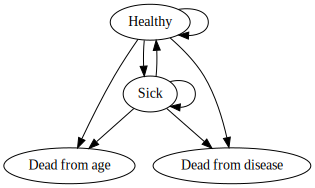

In [ ]:
states=['Healthy', 'Sick', 'Dead from age','Dead from disease']
make_graph(states)



In standard Markov models the transition probabilities cannot depend on time, but in Python it is quite easy to introduce time dependence. We introduce a new state 'Dead from age' we make the probability of dying from age increase every time unit. For instance, assume the people we model are often about 40 years old, and that the unit of time is one year. We could introduce a formula or a table that makes the probability of death dependent on time.

In [ ]:
#  the probability of death should be 0.1 every time period until time period 5, when it becomes 0.2, In timee period 10 it increases to 0.3 and so on
p_dead_from_age = {0:0.1, 5:0.2, 10: 0.3, 15:0.4, 20:0.4, 25:0.5}
           

But how can this be included in the model itself? Remember the transition matrix only has constant numbers, but now we want one of these numbers - the probablilyty of dying from age - to increase each time step, and the increase should be based on the information we provided in a table.

In [ ]:
transition_matrix = np.array([
       [0.8, 0.1, 0.1, 0.1],
       [0.2, 0.6, 0.2, 0.1],
       [0. , 0. , 1., 0. ],
       [0. , 0. , 0., 1. ]])


In [ ]:
cost = np.array([0,1000,0,0])
utility = np.array([0.9, .5, 0, 0])
initial_population=np.array([1,0,0,0])

In [ ]:
m = pd.DataFrame.from_dict(p_dead_from_age, orient='index')
m=  m.reindex(range(m.index.max())).fillna(method='ffill')
m

,0
0,0.1
1,0.1
2,0.1
3,0.1
4,0.1
5,0.2
6,0.2
7,0.2
8,0.2
9,0.2


In [ ]:
p_dead_from_age=m.to_dict()[0]

In [ ]:
p_dead_from_age

{0: 0.1,
 1: 0.1,
 2: 0.1,
 3: 0.1,
 4: 0.1,
 5: 0.2,
 6: 0.2,
 7: 0.2,
 8: 0.2,
 9: 0.2,
 10: 0.3,
 11: 0.3,
 12: 0.3,
 13: 0.3,
 14: 0.3,
 15: 0.4,
 16: 0.4,
 17: 0.4,
 18: 0.4,
 19: 0.4,
 20: 0.4,
 21: 0.4,
 22: 0.4,
 23: 0.4,
 24: 0.4}

In [ ]:
def descriptives(initial, probabilities, utility, cost, steps, p_dead_from_age=None):
  population = population_development(initial=initial, probabilities=probabilities, steps=steps, p_dead_from_age=p_dead_from_age)
  n_population = initial.sum()

  tot_cost = (population @ cost).sum()
  avg_cost = tot_cost/n_population

  tot_utility = (population @ utility).sum()
  avg_utility = tot_utility/n_population
  
  return avg_cost, avg_utility

In [ ]:
def population_development(initial, probabilities, steps,  p_dead_from_age=None):
  current_population = initial
  population_history = np.empty(shape=(steps+1,len(initial)))
  population_history[0] = initial

  for step in range(steps):
    probabilities[0,3]=p_dead_from_age[step]
    probabilities[1,3]=p_dead_from_age[step]
    
    new_population = current_population @ probabilities
    population_history[step+1] = new_population
    current_population=new_population
  return population_history


In [ ]:
%%timeit
descriptives(initial=initial_population, 
             probabilities = transition_matrix,
             utility=utility,
             cost=cost,
             p_dead_from_age=p_dead_from_age, 
             steps=20)

The slowest run took 9.23 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 55.2 µs per loop


## Challenge 2: age and dependent death rates from being sick


In [ ]:
transition_matrix = np.array([[0.8, 0.1, 0.1, 'table:general_mortality(time)'], [0.2, 0.6, 0.2, 'table:general_mortality(time)'], [0. , 0. , 1. , 'table:general_mortality(time)']])

In [ ]:
transition_matrix

array([['0.8', '0.1', '0.1', 'table:general_mortality(time)'],
       ['0.2', '0.6', '0.2', 'table:general_mortality(time)'],
       ['0.0', '0.0', '1.0', 'table:general_mortality(time)']],
      dtype='<U32')

In [ ]:
def text2num_matrix(matrix):
  for line in matrix:
    for element in line:
      in element.startswith('table:')
      
